# DATA 612 Project 2 - Joke Recommender System Part II

By Mike Silva

## Introduction

This is the continuation of the creation of a recommender system that provides users with jokes that they will find funny.  By providing this content we will keep users engaged longer on the website.

### About the Jester Dataset

For this project I will be using the [Jester dataset](http://eigentaste.berkeley.edu/dataset/).  It was created by Ken Goldberg at UC Berkley (Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001).

Data files are in .zip format, when unzipped, they are in Excel (.xls) format.  The ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" meaning "not rated").  Each row is a user.  The first column gives the number of jokes rated by the user. The next 100 give the ratings for jokes 1 to 100.  I will only be the first data set that has data for users that have rated 36 or more jokes.  

In addition to the ratings, we will be using the actual joke content.  It is also available through the website in a .zip file.  Each joke is in an HTML file.  There are comments in the HTML that indicate where the joke begins and where it ends.  I will note that some of the text in the HTML files is poorly done.  There are cases where there aren't spaces after punctuation marks and they didn't follow HTML standards.  There will be some cleanup of the text of the jokes.

### data612

This notebook relies on the module I created for this class.  You can see the [data612 module here](https://github.com/mikeasilva/CUNY-SPS/blob/master/DATA612/data612.py).

## Data Aquisition

We will begin by loading the libraries we need and aquiring the data.  As I previously noted, the ratings were previously downloaded in Part I; but I include the code in case someone starts from this juncture.  Let's download the joke text and the ratings.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import scipy.cluster.hierarchy as hclust
import seaborn as sb
from shutil import rmtree
from sklearn.preprocessing import normalize
import zipfile
# Import my custom module for this class
import data612

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("jester_dataset_1_joke_texts.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_joke_texts.zip", "wb") as f:
            f.write(response.content)
## This was done in Part I but we will include this just in case
if not os.path.exists("jester_dataset_1_1.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_1.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT ALL FILES
if not os.path.exists("jokes"):
    with zipfile.ZipFile("jester_dataset_1_joke_texts.zip","r") as z:
        z.extractall()
    # CLEANUP
    rmtree("__MACOSX")
## Again this was done in Part I but we are including this just in case
if not os.path.exists("jester-data-1.xls"):
    with zipfile.ZipFile("jester_dataset_1_1.zip","r") as z:
        z.extract("jester-data-1.xls")


## Content-Based Filtering

In this section I will develop a content-based filtering.  The recommender system will recommend jokes based on similar content.  Now that the jokes have been downloaded we need to read in the joke text into a list for processing:

In [2]:
jokes = list()

for n in range(1, 101):
    joke_text = data612.read_joke(n)
    jokes.append(joke_text)

### Bag of Words

Now that we have the counts we can begin forming a term frequency matrix or bag of words. To illustrate what I mean I will pass in the joke text into the bag_or_words function:

In [3]:
data612.bag_of_words(jokes)

word,!,!',"""a","""actually","""agh,","""ah,","""amal.""","""an","""and","""anybody",...,"you,",you.,"you.""",you.you,you?,"you?""",young,younger,your,yourself
index,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see there are 2,073 terms in the bag of words, however some of them should be combined.  I created the preprocess_jokes() function that allows me to clean up the text.  There are multiple transformation that can be preformed but they must be explicitly called.  I'm going to remove all contractions (I'm becomes I am), numbers and puctuation from the jokes.  I am also going to lemmatize the words.

In [4]:
preprocessed_jokes = data612.preprocess_jokes(jokes, remove_contractions = True, remove_numbers = True, remove_punctuation_marks = True, lemmatize_words = True)
term_frequency_matrix = data612.bag_of_words(preprocessed_jokes)
term_frequency_matrix

word,a,abortion,about,above,accompanied,accounting,acquitted,actual,actually,add,...,yesterdaya,york,you,young,younger,your,yourself,youyou,zipper,zool
index,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,0,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
97,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are now 1,438 terms in the matrix.  I am going to use this matrix to form the content based recommendations.  In addition to it I will use a normalized matrix:

In [5]:
normalized_term_frequency_matrix = data612.bag_of_words(preprocessed_jokes, normalize = True)
normalized_term_frequency_matrix

word,a,abortion,about,above,accompanied,accounting,acquitted,actual,actually,add,...,yesterdaya,york,you,young,younger,your,yourself,youyou,zipper,zool
index,,,,,,,,,,,,,,,,,,,,,
1,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0
2,0.190693,0.0,0.095346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.190693,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.458831,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.640513,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.320256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
5,0.192450,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.104257,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.104257,0.0,0.0,0.104257,0.0,0.000000,0.0,0.0
97,0.578542,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
98,0.063758,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


### Similar Jokes

Now that we have the term frequence matrices we need to find which jokes are similar.  There are multiple approaches we could use.  We're going to try a couple of them out and see how their results change.

#### Cosine Similarity

The first way we will find similar content is based off of the cosine similarity.  Cosine similarity ranged from -1 to 1 with 1 being perfectly similar and -1 being perfectly dissimilar.

In [6]:
cosine_similarity_df = data612.cosine_similarity(term_frequency_matrix)
normalized_cosine_similarity_df = data612.cosine_similarity(normalized_term_frequency_matrix)

Let's visualize the cosine similaries in a heatmap.

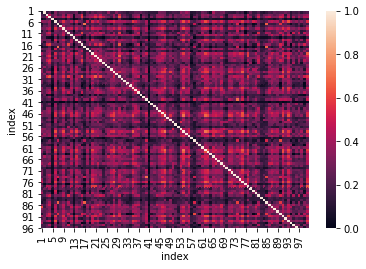

In [7]:
sb.heatmap(cosine_similarity_df)

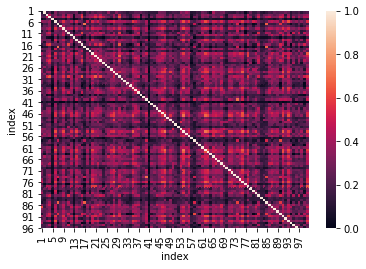

In [8]:
sb.heatmap(normalized_cosine_similarity_df)

#### Hierarchical Clustering

We can also hierarchical clusterning to find similar jokes.  We will base this on the cosine difference.

In [9]:
cosine_difference_df = data612.cosine_similarity(term_frequency_matrix, return_difference = True)
normalized_cosine_difference_df = data612.cosine_similarity(normalized_term_frequency_matrix, return_difference = True)
cosine_difference_df

index,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
index,,,,,,,,,,,,,,,,,,,,,
1,1.110223e-16,0.904654,8.033579e-01,0.748370,9.725071e-01,0.624761,0.928571,0.857143,0.714919,0.904169,...,0.625986,0.802197,0.666526,0.587918,0.823653,0.806379,0.853069,8.178352e-01,8.155722e-01,0.636345
2,9.046537e-01,0.000000,8.468825e-01,0.770986,9.266024e-01,0.667779,0.809307,0.737798,0.708252,0.765479,...,0.767892,0.720121,0.759860,0.895225,0.823453,0.840951,0.791611,8.844979e-01,8.276719e-01,0.797740
3,8.033579e-01,0.846882,2.220446e-16,0.522433,7.792446e-01,0.692551,0.827938,0.770584,0.618487,0.846103,...,0.546891,0.885645,0.619492,0.873949,0.752203,0.760818,0.690305,7.074597e-01,6.445907e-01,0.610669
4,7.483700e-01,0.770986,5.224331e-01,0.000000,7.842833e-01,0.605147,0.679744,0.679744,0.531331,0.713554,...,0.507220,0.804889,0.527843,0.868028,0.579959,0.766277,0.588263,7.243462e-01,5.452060e-01,0.547089
5,9.725071e-01,0.926602,7.792446e-01,0.784283,-2.220446e-16,0.938102,0.903775,0.903775,0.884786,0.956967,...,0.885086,0.968024,0.905423,1.000000,0.910913,0.979936,0.876288,9.141088e-01,8.260836e-01,0.863917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,8.063795e-01,0.840951,7.608176e-01,0.766277,9.799357e-01,0.625552,0.895743,0.869678,0.708726,0.720249,...,0.626482,0.774803,0.647754,0.813829,0.710430,0.000000,0.825750,7.075233e-01,9.327023e-01,0.734604
97,8.530687e-01,0.791611,6.903046e-01,0.588263,8.762884e-01,0.731220,0.742870,0.807153,0.598056,0.755642,...,0.660452,0.829107,0.664349,0.876382,0.672673,0.825750,0.000000,8.565526e-01,6.099551e-01,0.745455
98,8.178352e-01,0.884498,7.074597e-01,0.724346,9.141088e-01,0.644552,0.872485,0.920303,0.694641,0.885947,...,0.581226,0.834033,0.600507,0.851118,0.901620,0.707523,0.856553,2.220446e-16,8.600716e-01,0.639332


In [10]:
"""
df = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)
df = df.drop([0], axis=1)
df = data612.rescale_jester_ratings(df)#.fillna(0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.mean(axis=0))
"""

'\ndf = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)\ndf = df.drop([0], axis=1)\ndf = data612.rescale_jester_ratings(df)#.fillna(0)\nwith pd.option_context(\'display.max_rows\', None, \'display.max_columns\', None):  # more options can be specified also\n    print(df.mean(axis=0))\n'